#### Imports

In [83]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib
import random
from matplotlib import pyplot as plt 
import numpy as np
import gc
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import ranksums
from xgboost import XGBClassifier
from lightgbm import LGBMModel,LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import neptune.new as neptune
%matplotlib inline
pd.set_option('display.max_columns', None)

#### Helper functions

In [84]:
def reduce_mem_usage(data: pd.DataFrame, verbose = True) -> pd.DataFrame:
    """
    Reduces memory usage of a dataframe 
    
    Args:
        data: dataframe
        
    Returns:
        dataframe
    """
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

In [85]:
def one_hot_encoder(data: pd.DataFrame, nan_as_category = True) -> pd.DataFrame:
    """
    Replaces missing categorical values and encodes them.
    
    Args:
        data: dataframe
        
    Returns:
        encoded data
    """
    
    original_columns = list(data.columns)
    categorical_columns = [col for col in data.columns \
                           if not pd.api.types.is_numeric_dtype(data[col].dtype)]
    for c in categorical_columns:
        if nan_as_category:
            data[c].fillna('NaN', inplace = True)
        values = list(data[c].unique())
        for v in values:
            data[str(c) + '_' + str(v)] = (data[c] == v).astype(np.uint8)
    data.drop(categorical_columns, axis = 1, inplace = True)
    return data, [c for c in data.columns if c not in original_columns]

In [86]:
def plot_feature_importances(df: pd.DataFrame) -> pd.DataFrame:
    """
    Plot importances returned by a model. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        """
    
    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    ax = plt.subplot()
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['features'].head(15))
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

### Functions for different datasets

#### Application train/test

In [87]:
df_train = pd.read_csv('application_train.csv')
df_test = pd.read_csv('application_test.csv')
df = pd.concat([df_train, df_test], axis = 0, ignore_index = True)

Outliers

In [88]:
df.drop(df[df['CODE_GENDER'] == 'XNA'].index, inplace = True)
df.drop(df[df['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace = True)
df.drop(df[df['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace = True)
df.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
df.loc[df['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
df.loc[df['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
df.loc[df['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
    
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], _ = pd.factorize(df[bin_feature])

Feature engineering

In [89]:
df, _ = one_hot_encoder(df)

In [90]:
df['app missing'] = df.isnull().sum(axis = 1).values

In [91]:
df['app EXT_SOURCE mean'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
df['app EXT_SOURCE std'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
df['app EXT_SOURCE prod'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['app EXT_SOURCE_1 * EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
df['app EXT_SOURCE_1 * EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
df['app EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * df['DAYS_EMPLOYED']
df['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
df['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']
df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
df['app EXT_SOURCE_2 / DAYS_BIRTH'] = df['EXT_SOURCE_2'] / df['DAYS_BIRTH']
df['app EXT_SOURCE_3 / DAYS_BIRTH'] = df['EXT_SOURCE_3'] / df['DAYS_BIRTH']

In [92]:
df['app AMT_CREDIT / AMT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['app AMT_CREDIT / AMT_ANNUITY'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['app AMT_CREDIT / AMT_INCOME_TOTAL'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

In [93]:
df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
df['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])

In [94]:
df['app OWN_CAR_AGE / DAYS_BIRTH'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['app OWN_CAR_AGE / DAYS_EMPLOYED'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']

In [95]:
df['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
df['app DAYS_EMPLOYED - DAYS_BIRTH'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']

In [96]:
df['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']

In [97]:
application_train_test = reduce_mem_usage(df)
application_train_test.head()

Memory usage of dataframe: 389.00 MB
Memory usage after optimization: 179.38 MB
Decreased by 53.9%


SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   
3      100006     0.0            1             0                0   
4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018799       -9461         -637.0            -3648.0   
1                    0.003542      -16765        -1188.0            -1186.0   
2                    0.010033      -19046         -225.0            -4260.0   
3                    0.008018      -19005        -3040.0            -9832.0   
4                    0.028656      -19932        -3038.0            -4312.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                          2.0                       10   
1                     1                          1.0                       11   
2                     2                          2.0                        9   
3                     2                          2.0                       17   
4                     2                          2.0                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083008   
1                       0                        0      0.311279   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262939      0.139404        0.024704          0.036896   
1      0.622070           

#### Bureau and balance

In [98]:
df_bureau_b = reduce_mem_usage(pd.read_csv('bureau_balance.csv'), verbose = False)
df_bureau_b.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

Feature engineering

In [99]:
tmp = df_bureau_b[['SK_ID_BUREAU', 'STATUS']].groupby('SK_ID_BUREAU')
tmp_last = tmp.last()
tmp_last.columns = ['First_status']
df_bureau_b = df_bureau_b.join(tmp_last, how = 'left', on = 'SK_ID_BUREAU')
tmp_first = tmp.first()
tmp_first.columns = ['Last_status']
df_bureau_b = df_bureau_b.join(tmp_first, how = 'left', on = 'SK_ID_BUREAU')

In [100]:
tmp = df_bureau_b[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').last()
tmp = tmp.apply(abs)
tmp.columns = ['Month']
df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')

In [101]:
tmp = df_bureau_b.loc[df_bureau_b['STATUS'] == 'C', ['SK_ID_BUREAU', 'MONTHS_BALANCE']] \
                .groupby('SK_ID_BUREAU').last()
tmp = tmp.apply(abs)
tmp.columns = ['When_closed']
df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
df_bureau_b['Month_closed_to_end'] = df_bureau_b['Month'] - df_bureau_b['When_closed']

In [102]:
for c in range(6):
    tmp = df_bureau_b.loc[df_bureau_b['STATUS'] == str(c), ['SK_ID_BUREAU', 'MONTHS_BALANCE']] \
                         .groupby('SK_ID_BUREAU').count()
    tmp.columns = ['DPD_' + str(c) + '_cnt']
df_bureau_b = df_bureau_b.join(tmp, how = 'left', on = 'SK_ID_BUREAU')
df_bureau_b['DPD_' + str(c) + ' / Month'] = df_bureau_b['DPD_' + str(c) + '_cnt'] / df_bureau_b['Month']

In [104]:
df_bureau_b, bureau_b_cat = one_hot_encoder(df_bureau_b)

aggregations = {}
for col in df_bureau_b.columns:
    aggregations[col] = ['mean'] if col in bureau_b_cat else ['min', 'max', 'size']
df_bureau_b_agg = df_bureau_b.groupby('SK_ID_BUREAU').agg(aggregations)
df_bureau_b_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in df_bureau_b_agg.columns.tolist()])

Outliers

In [105]:
df_bureau = reduce_mem_usage(pd.read_csv('bureau.csv'), verbose = False)

In [106]:
df_bureau.loc[df_bureau['AMT_ANNUITY'] > .8e8, 'AMT_ANNUITY'] = np.nan
df_bureau.loc[df_bureau['AMT_CREDIT_SUM'] > 3e8, 'AMT_CREDIT_SUM'] = np.nan
df_bureau.loc[df_bureau['AMT_CREDIT_SUM_DEBT'] > 1e8, 'AMT_CREDIT_SUM_DEBT'] = np.nan
df_bureau.loc[df_bureau['AMT_CREDIT_MAX_OVERDUE'] > .8e8, 'AMT_CREDIT_MAX_OVERDUE'] = np.nan
df_bureau.loc[df_bureau['DAYS_ENDDATE_FACT'] < -10000, 'DAYS_ENDDATE_FACT'] = np.nan
df_bureau.loc[(df_bureau['DAYS_CREDIT_UPDATE'] > 0) | (df_bureau['DAYS_CREDIT_UPDATE'] < -40000), 'DAYS_CREDIT_UPDATE'] = np.nan
df_bureau.loc[df_bureau['DAYS_CREDIT_ENDDATE'] < -10000, 'DAYS_CREDIT_ENDDATE'] = np.nan
df_bureau.drop(df_bureau[df_bureau['DAYS_ENDDATE_FACT'] < df_bureau['DAYS_CREDIT']].index, inplace = True)

Feature engineering

In [107]:
df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_DEBT']
df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_LIMIT']
df_bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_OVERDUE']

In [108]:
df_bureau['bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE'] = df_bureau['DAYS_CREDIT'] - df_bureau['CREDIT_DAY_OVERDUE']
df_bureau['bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_CREDIT_ENDDATE']
df_bureau['bureau DAYS_CREDIT - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_ENDDATE_FACT']
df_bureau['bureau DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT_ENDDATE'] - df_bureau['DAYS_ENDDATE_FACT']
df_bureau['bureau DAYS_CREDIT_UPDATE - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT_UPDATE'] - df_bureau['DAYS_CREDIT_ENDDATE']

In [109]:
df_bureau, bureau_cat = one_hot_encoder(df_bureau)

In [110]:
df_bureau = df_bureau.join(df_bureau_b_agg, how = 'left', on = 'SK_ID_BUREAU')
df_bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True)

In [111]:
categorical = bureau_cat + bureau_b_cat
aggregations = {}
for col in df_bureau.columns:
    aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
df_bureau_agg = df_bureau.groupby('SK_ID_CURR').agg(aggregations)
df_bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in df_bureau_agg.columns.tolist()])

In [112]:
active_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Active'] == 1].groupby('SK_ID_CURR').agg(aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
df_bureau_agg = df_bureau_agg.join(active_agg, how = 'left')

In [113]:
closed_agg = df_bureau[df_bureau['CREDIT_ACTIVE_Closed'] == 1].groupby('SK_ID_CURR').agg(aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
df_bureau_agg = df_bureau_agg.join(closed_agg, how = 'left')

In [114]:
bureau_and_balance = reduce_mem_usage(df_bureau_agg)
bureau_and_balance.head()

Memory usage of dataframe: 2650.06 MB
Memory usage after optimization: 873.37 MB
Decreased by 67.0%


BURO_SK_ID_CURR_MIN  BURO_SK_ID_CURR_MAX  BURO_SK_ID_CURR_SIZE  \
SK_ID_CURR                                                                   
100001                   100001               100001                     7   
100002                   100002               100002                     8   
100003                   100003               100003                     4   
100004                   100004               100004                     2   
100005                   100005               100005                     3   

            BURO_SK_ID_CURR_MEAN  BURO_SK_ID_CURR_VAR  BURO_SK_ID_CURR_SUM  \
SK_ID_CURR                                                                   
100001                  100001.0                  0.0               700007   
100002                  100002.0                  0.0               800016   
100003                  100003.0                  0.0               400012   
100004                  100004.0                  0.0               200008   
100005                  100005.0                  0.0               300015   

            BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_SIZE  \
SK_ID_CURR                                                                      
100001                     -1572                   -49                      7   
100002                     -1437                  -103                      8   
100003                     -2586                  -606                      4   
100004                     -1326                  -408                      2   
100005                      -373                   -62                      3   

            BURO_DAYS_CREDIT_MEAN  BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_SUM  \
SK_ID_CURR                                                                      
100001                   -735.000         240043.671875               -5145.0   
100002                   -874.000         186150.000000               -6992.0   
100003                  -1401.000         827783.562500               -5603.0   
100004                   -867.000         421362.000000               -1734.0   
100005                   -190.625          26340.333984                -572.0   

            BURO_CREDIT_DAY_OVERDUE_MIN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                             
100001                                0                            0   
100002                                0                            0   
100003                                0                            0   
100004                                0                            0   
100005                                0                            0   

            BURO_CREDIT_DAY_OVERDUE_SIZE  BURO_CREDIT_DAY_OVERDUE_MEAN  \
SK_ID_CURR                                                               
100001                                 7                           0.0   
100002                                 8                           0.0   
100003                                 4                           0.0   
100004                                 2                           0.0   
100005                                 3                           0.0   

            BURO_CREDIT_DAY_OVERDUE_VAR  BURO_CREDIT_DAY_OVERDUE_SUM  \
SK_ID_CURR                                                             
100001                              0.0                            0   
100002                              0.0                            0   
100003                              0.0                            0   
100004                              0.0                            0   
100005                              0.0                            0   

            BURO_DAYS_CREDIT_ENDDATE_MIN  BURO_DAYS_CREDIT_ENDDATE_MAX  \
SK_ID_CURR                                                               
100001                           -1329.0                        1778.0   
100002                         

#### Previous application

In [115]:
df_prev = pd.read_csv('previous_application.csv')

Outliers

In [116]:
df_prev.loc[df_prev['AMT_CREDIT'] > 6000000, 'AMT_CREDIT'] = np.nan
df_prev.loc[df_prev['SELLERPLACE_AREA'] > 3500000, 'SELLERPLACE_AREA'] = np.nan
df_prev[['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
        'DAYS_LAST_DUE', 'DAYS_TERMINATION']].replace(365243, np.nan, inplace = True)

Feature engineering

In [117]:
df_prev['prev missing'] = df_prev.isnull().sum(axis = 1).values
df_prev['prev AMT_APPLICATION / AMT_CREDIT'] = df_prev['AMT_APPLICATION'] / df_prev['AMT_CREDIT']
df_prev['prev AMT_APPLICATION - AMT_GOODS_PRICE'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_GOODS_PRICE']
df_prev['prev AMT_GOODS_PRICE - AMT_CREDIT'] = df_prev['AMT_GOODS_PRICE'] - df_prev['AMT_CREDIT']
df_prev['prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE'] = df_prev['DAYS_FIRST_DRAWING'] - df_prev['DAYS_FIRST_DUE']
df_prev['prev DAYS_TERMINATION less -500'] = (df_prev['DAYS_TERMINATION'] < -500).astype(int)

In [118]:
df_prev, categorical = one_hot_encoder(df_prev)

In [119]:
aggregations = {}
for col in df_prev.columns:
    aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
df_prev_agg = df_prev.groupby('SK_ID_CURR').agg(aggregations)
df_prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df_prev_agg.columns.tolist()])

In [120]:
approved_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Approved'] == 1].groupby('SK_ID_CURR').agg(aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
df_prev_agg = df_prev_agg.join(approved_agg, how = 'left')

In [121]:
refused_agg = df_prev[df_prev['NAME_CONTRACT_STATUS_Refused'] == 1].groupby('SK_ID_CURR').agg(aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
df_prev_agg = df_prev_agg.join(refused_agg, how = 'left')

In [122]:
previous_application = reduce_mem_usage(df_prev_agg)
previous_application.head()

Memory usage of dataframe: 2387.81 MB
Memory usage after optimization: 801.42 MB
Decreased by 66.4%


PREV_SK_ID_PREV_MIN  PREV_SK_ID_PREV_MAX  PREV_SK_ID_PREV_SIZE  \
SK_ID_CURR                                                                   
100001                  1369693              1369693                     1   
100002                  1038818              1038818                     1   
100003                  1810518              2636178                     3   
100004                  1564014              1564014                     1   
100005                  1857999              2495675                     2   

            PREV_SK_ID_PREV_MEAN  PREV_SK_ID_PREV_VAR  PREV_SK_ID_PREV_SUM  \
SK_ID_CURR                                                                   
100001                1369693.00                  NaN              1369693   
100002                1038818.00                  NaN              1038818   
100003                2281150.25         1.804519e+11              6843451   
100004                1564014.00                  NaN              1564014   
100005                2176837.00         2.033153e+11              4353674   

            PREV_SK_ID_CURR_MIN  PREV_SK_ID_CURR_MAX  PREV_SK_ID_CURR_SIZE  \
SK_ID_CURR                                                                   
100001                   100001               100001                     1   
100002                   100002               100002                     1   
100003                   100003               100003                     3   
100004                   100004               100004                     1   
100005                   100005               100005                     2   

            PREV_SK_ID_CURR_MEAN  PREV_SK_ID_CURR_VAR  PREV_SK_ID_CURR_SUM  \
SK_ID_CURR                                                                   
100001                  100001.0                  NaN               100001   
100002                  100002.0                  NaN               100002   
100003                  100003.0                  0.0               300009   
100004                  100004.0                  NaN               100004   
100005                  100005.0                  0.0               200010   

            PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_SIZE  \
SK_ID_CURR                                                                      
100001               3951.000000           3951.000000                      1   
100002               9251.775391           9251.775391                      1   
100003               6737.310059          98356.992188                      3   
100004               5357.250000           5357.250000                      1   
100005               4813.200195           4813.200195                      2   

            PREV_AMT_ANNUITY_MEAN  PREV_AMT_ANNUITY_VAR  PREV_AMT_ANNUITY_SUM  \
SK_ID_CURR                                                                      
100001                3951.000000                   NaN           3951.000000   
100002                9251.775391                   NaN           9251.775391   
100003               56553.988281          2.146706e+09         169661.968750   
100004                5357.250000                   NaN           5357.250000   
100005                4813.200195                   NaN           4813.200195   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                       68809.5                  900000.0   
100004                       24282.0                   24282.0   
100005                           0.0                   44617.5   

            PREV_AMT_APPLICATION_SIZE  PREV_AMT_APPLICATION_MEAN  \
SK_ID_CURR                                                         
100001                              1                   24835.50   
100002               

#### Pos cash

In [124]:
df_pos = pd.read_csv('POS_CASH_balance.csv')

Outliers

In [127]:
df_pos.loc[df_pos['CNT_INSTALMENT_FUTURE'] > 60, 'CNT_INSTALMENT_FUTURE'] = np.nan

In [128]:
df_pos, categorical = one_hot_encoder(df_pos)

Feature engineering

In [129]:
aggregations = {}
for col in df_pos.columns:
    aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
df_pos_agg = df_pos.groupby('SK_ID_CURR').agg(aggregations)
df_pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in df_pos_agg.columns.tolist()])
df_pos_agg['POS_COUNT'] = df_pos.groupby('SK_ID_CURR').size()

In [130]:
pos_cash = reduce_mem_usage(df_pos_agg)
pos_cash.head()

Memory usage of dataframe: 136.37 MB
Memory usage after optimization: 43.74 MB
Decreased by 67.9%


POS_SK_ID_PREV_MIN  POS_SK_ID_PREV_MAX  POS_SK_ID_PREV_SIZE  \
SK_ID_CURR                                                                
100001                 1369693             1851984                    9   
100002                 1038818             1038818                   19   
100003                 1810518             2636178                   28   
100004                 1564014             1564014                    4   
100005                 2495675             2495675                   11   

            POS_SK_ID_PREV_MEAN  POS_SK_ID_PREV_VAR  POS_SK_ID_PREV_SUM  \
SK_ID_CURR                                                                
100001               1584044.50        6.461239e+10            14256401   
100002               1038818.00        0.000000e+00            19737542   
100003               2297665.25        1.086316e+11            64334628   
100004               1564014.00        0.000000e+00             6256056   
100005               2495675.00        0.000000e+00            27452425   

            POS_SK_ID_CURR_MIN  POS_SK_ID_CURR_MAX  POS_SK_ID_CURR_SIZE  \
SK_ID_CURR                                                                
100001                  100001              100001                    9   
100002                  100002              100002                   19   
100003                  100003              100003                   28   
100004                  100004              100004                    4   
100005                  100005              100005                   11   

            POS_SK_ID_CURR_MEAN  POS_SK_ID_CURR_VAR  POS_SK_ID_CURR_SUM  \
SK_ID_CURR                                                                
100001                 100001.0                 0.0              900009   
100002                 100002.0                 0.0             1900038   
100003                 100003.0                 0.0             2800084   
100004                 100004.0                 0.0              400016   
100005                 100005.0                 0.0             1100055   

            POS_MONTHS_BALANCE_MIN  POS_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                   
100001                         -96                     -53   
100002                         -19                      -1   
100003                         -77                     -18   
100004                         -27                     -24   
100005                         -25                     -15   

            POS_MONTHS_BALANCE_SIZE  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                     
100001                            9                -72.56250   
100002                           19                -10.00000   
100003                           28                -43.78125   
100004                            4                -25.50000   
100005                           11                -20.00000   

            POS_MONTHS_BALANCE_VAR  POS_MONTHS_BALANCE_SUM  \
SK_ID_CURR                                                   
100001                  435.250000                    -653   
100002                   31.671875                    -190   
100003                  607.000000                   -1226   
100004                    1.666992                    -102   
100005                   11.000000                    -220   

            POS_CNT_INSTALMENT_MIN  POS_CNT_INSTALMENT_MAX  \
SK_ID_CURR                                                   
100001                         4.0                     4.0   
100002                        24.0                    24.0   
100003                         6.0                    12.0   
100004                         3.0                     4.0   
100005                         9.0                    12.0   

            POS_CNT_INSTALMENT_SIZE  POS_CNT_INSTALMENT_MEAN  \
SK_ID_CURR                                                     
100001                    

#### Installments payments

In [132]:
df_ins = pd.read_csv('installments_payments.csv')

Outliers

In [133]:
df_ins.loc[df_ins['NUM_INSTALMENT_VERSION'] > 70, 'NUM_INSTALMENT_VERSION'] = np.nan
df_ins.loc[df_ins['DAYS_ENTRY_PAYMENT'] < -4000, 'DAYS_ENTRY_PAYMENT'] = np.nan

Feature engineering

In [134]:
df_ins['ins DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT'] = df_ins['DAYS_ENTRY_PAYMENT'] - df_ins['DAYS_INSTALMENT']
df_ins['ins NUM_INSTALMENT_NUMBER_100'] = (df_ins['NUM_INSTALMENT_NUMBER'] == 100).astype(int)
df_ins['ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER'] = (df_ins['DAYS_INSTALMENT'] > df_ins['NUM_INSTALMENT_NUMBER'] * 50 / 3 - 11500 / 3).astype(int)
df_ins['ins AMT_INSTALMENT - AMT_PAYMENT'] = df_ins['AMT_INSTALMENT'] - df_ins['AMT_PAYMENT']
df_ins['ins AMT_PAYMENT / AMT_INSTALMENT'] = df_ins['AMT_PAYMENT'] / df_ins['AMT_INSTALMENT']

In [136]:
df_ins, categorical = one_hot_encoder(df_ins)

In [138]:
aggregations = {}
for col in df_ins.columns:
    aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
df_ins_agg = df_ins.groupby('SK_ID_CURR').agg(aggregations)
df_ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in df_ins_agg.columns.tolist()])
df_ins_agg['INSTAL_COUNT'] = df_ins.groupby('SK_ID_CURR').size()

In [139]:
installments_payments = reduce_mem_usage(df_ins_agg)
installments_payments.head()

Memory usage of dataframe: 199.49 MB
Memory usage after optimization: 77.08 MB
Decreased by 61.4%


INS_SK_ID_PREV_MIN  INS_SK_ID_PREV_MAX  INS_SK_ID_PREV_SIZE  \
SK_ID_CURR                                                                
100001                 1369693             1851984                    7   
100002                 1038818             1038818                   19   
100003                 1810518             2636178                   25   
100004                 1564014             1564014                    3   
100005                 2495675             2495675                    9   

            INS_SK_ID_PREV_MEAN  INS_SK_ID_PREV_VAR  INS_SK_ID_PREV_SUM  \
SK_ID_CURR                                                                
100001              1576389.125        6.645846e+10            11034724   
100002              1038818.000        0.000000e+00            19737542   
100003              2290070.250        1.027131e+11            57251754   
100004              1564014.000        0.000000e+00             4692042   
100005              2495675.000        0.000000e+00            22461075   

            INS_SK_ID_CURR_MIN  INS_SK_ID_CURR_MAX  INS_SK_ID_CURR_SIZE  \
SK_ID_CURR                                                                
100001                  100001              100001                    7   
100002                  100002              100002                   19   
100003                  100003              100003                   25   
100004                  100004              100004                    3   
100005                  100005              100005                    9   

            INS_SK_ID_CURR_MEAN  INS_SK_ID_CURR_VAR  INS_SK_ID_CURR_SUM  \
SK_ID_CURR                                                                
100001                 100001.0                 0.0              700007   
100002                 100002.0                 0.0             1900038   
100003                 100003.0                 0.0             2500075   
100004                 100004.0                 0.0              300012   
100005                 100005.0                 0.0              900045   

            INS_NUM_INSTALMENT_VERSION_MIN  INS_NUM_INSTALMENT_VERSION_MAX  \
SK_ID_CURR                                                                   
100001                                 1.0                             2.0   
100002                                 1.0                             2.0   
100003                                 1.0                             2.0   
100004                                 1.0                             2.0   
100005                                 1.0                             2.0   

            INS_NUM_INSTALMENT_VERSION_SIZE  INS_NUM_INSTALMENT_VERSION_MEAN  \
SK_ID_CURR                                                                     
100001                                    7                         1.142578   
100002                                   19                         1.052734   
100003                                   25                         1.040039   
100004                                    3                         1.333008   
100005                                    9                         1.111328   

            INS_NUM_INSTALMENT_VERSION_VAR  INS_NUM_INSTALMENT_VERSION_SUM  \
SK_ID_CURR                                                                   
100001                            0.142822                             8.0   
100002                            0.052643                            20.0   
100003                            0.040009                            26.0   
100004                            0.333252                             4.0   
100005                            0.111084                            10.0   

            INS_NUM_INSTALMENT_NUMBER_MIN  INS_NUM_INSTALMENT_NUMBER_MAX  \
SK_ID_CURR                                                                 
100001                                  1                              4   
100002                   

#### Credit card balance

In [140]:
df_card = pd.read_csv('credit_card_balance.csv')

Outliers

In [141]:
df_card.loc[df_card['AMT_PAYMENT_CURRENT'] > 4000000, 'AMT_PAYMENT_CURRENT'] = np.nan
df_card.loc[df_card['AMT_CREDIT_LIMIT_ACTUAL'] > 1000000, 'AMT_CREDIT_LIMIT_ACTUAL'] = np.nan

Feature engineering

In [142]:
df_card['card missing'] = df_card.isnull().sum(axis = 1).values
df_card['card SK_DPD - MONTHS_BALANCE'] = df_card['SK_DPD'] - df_card['MONTHS_BALANCE']
df_card['card SK_DPD_DEF - MONTHS_BALANCE'] = df_card['SK_DPD_DEF'] - df_card['MONTHS_BALANCE']
df_card['card SK_DPD - SK_DPD_DEF'] = df_card['SK_DPD'] - df_card['SK_DPD_DEF']

In [143]:
df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECIVABLE']
df_card['card AMT_TOTAL_RECEIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
df_card['card AMT_RECIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_RECIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']

In [144]:
df_card['card AMT_BALANCE - AMT_RECIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_RECIVABLE']
df_card['card AMT_BALANCE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_BALANCE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
df_card['card AMT_BALANCE - AMT_TOTAL_RECEIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_TOTAL_RECEIVABLE']

In [145]:
df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_ATM_CURRENT']
df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_OTHER_CURRENT']
df_card['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_POS_CURRENT']

In [146]:
df_card, categorical = one_hot_encoder(df_card)

In [147]:
aggregations = {}
for col in df_card.columns:
    aggregations[col] = ['mean'] if col in categorical else ['min', 'max', 'size', 'mean', 'var', 'sum']
df_card_agg = df_card.groupby('SK_ID_CURR').agg(aggregations)
df_card_agg.columns = pd.Index(['CARD_' + e[0] + "_" + e[1].upper() for e in df_card_agg.columns.tolist()])
df_card_agg['CARD_COUNT'] = df_card.groupby('SK_ID_CURR').size()

In [148]:
credit_card_balance = reduce_mem_usage(df_card_agg)
credit_card_balance.head()

Memory usage of dataframe: 173.03 MB
Memory usage after optimization: 66.37 MB
Decreased by 61.6%


CARD_SK_ID_PREV_MIN  CARD_SK_ID_PREV_MAX  CARD_SK_ID_PREV_SIZE  \
SK_ID_CURR                                                                   
100006                  1489396              1489396                     6   
100011                  1843384              1843384                    74   
100013                  2038692              2038692                    96   
100021                  2594025              2594025                    17   
100023                  1499902              1499902                     8   

            CARD_SK_ID_PREV_MEAN  CARD_SK_ID_PREV_VAR  CARD_SK_ID_PREV_SUM  \
SK_ID_CURR                                                                   
100006                 1489396.0                  0.0              8936376   
100011                 1843384.0                  0.0            136410416   
100013                 2038692.0                  0.0            195714432   
100021                 2594025.0                  0.0             44098425   
100023                 1499902.0                  0.0             11999216   

            CARD_SK_ID_CURR_MIN  CARD_SK_ID_CURR_MAX  CARD_SK_ID_CURR_SIZE  \
SK_ID_CURR                                                                   
100006                   100006               100006                     6   
100011                   100011               100011                    74   
100013                   100013               100013                    96   
100021                   100021               100021                    17   
100023                   100023               100023                     8   

            CARD_SK_ID_CURR_MEAN  CARD_SK_ID_CURR_VAR  CARD_SK_ID_CURR_SUM  \
SK_ID_CURR                                                                   
100006                  100006.0                  0.0               600036   
100011                  100011.0                  0.0              7400814   
100013                  100013.0                  0.0              9601248   
100021                  100021.0                  0.0              1700357   
100023                  100023.0                  0.0               800184   

            CARD_MONTHS_BALANCE_MIN  CARD_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                     
100006                           -6                       -1   
100011                          -75                       -2   
100013                          -96                       -1   
100021                          -18                       -2   
100023                          -11                       -4   

            CARD_MONTHS_BALANCE_SIZE  CARD_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                       
100006                             6                      -3.5   
100011                            74                     -38.5   
100013                            96                     -48.5   
100021                            17                     -10.0   
100023                             8                      -7.5   

            CARD_MONTHS_BALANCE_VAR  CARD_MONTHS_BALANCE_SUM  \
SK_ID_CURR                                                     
100006                          3.5                      -21   
100011                        462.5                    -2849   
100013                        776.0                    -4656   
100021                         25.5                     -170   
100023                          6.0                      -60   

            CARD_AMT_BALANCE_MIN  CARD_AMT_BALANCE_MAX  CARD_AMT_BALANCE_SIZE  \
SK_ID_CURR                                                                      
100006                       0.0               0.00000                      6   
100011                       0.0          189000.00000                     74   
100013                       0.0          161420.21875                     96   
100021                       0.0               0.00000    

### Aggregating all data

In [150]:
df = application_train_test
bureau = bureau_and_balance
df = df.join(bureau, how = 'left', on = 'SK_ID_CURR')
prev = previous_application
df = df.join(prev, how = 'left', on = 'SK_ID_CURR')
pos = pos_cash
df = df.join(pos, how = 'left', on = 'SK_ID_CURR')
ins = installments_payments
df = df.join(ins, how = 'left', on = 'SK_ID_CURR')
cc = credit_card_balance
df = df.join(cc, how = 'left', on = 'SK_ID_CURR')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe: 2878.96 MB
Memory usage after optimization: 2403.33 MB
Decreased by 16.5%


SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   
3      100006     0.0            1             0                0   
4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018799       -9461         -637.0            -3648.0   
1                    0.003542      -16765        -1188.0            -1186.0   
2                    0.010033      -19046         -225.0            -4260.0   
3                    0.008018      -19005        -3040.0            -9832.0   
4                    0.028656      -19932        -3038.0            -4312.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                          2.0                       10   
1                     1                          1.0                       11   
2                     2                          2.0                        9   
3                     2                          2.0                       17   
4                     2                          2.0                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083008   
1                       0                        0      0.311279   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262939      0.139404        0.024704          0.036896   
1      0.622070           

### Cleaning data

In [151]:
df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace=True)
df.shape

(356244, 2789)

In [153]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Reduces feature count:
    removes empty features
    
    Args:
        data: dataframe
        
    Returns:
        dataframe
    """
    
    warnings.simplefilter(action = 'ignore')
    
    nun = data.nunique()
    empty = list(nun[nun <= 1].index)
    
    data.drop(empty, axis = 1, inplace = True)
    print('After removing empty features there are {0:d} features'.format(data.shape[1]))
    return data

In [154]:
df = clean_data(df)
df.head()

After removing empty features there are 2667 features


SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   
3      100006     0.0            1             0                0   
4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018799       -9461         -637.0            -3648.0   
1                    0.003542      -16765        -1188.0            -1186.0   
2                    0.010033      -19046         -225.0            -4260.0   
3                    0.008018      -19005        -3040.0            -9832.0   
4                    0.028656      -19932        -3038.0            -4312.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                          2.0                       10   
1                     1                          1.0                       11   
2                     2                          2.0                        9   
3                     2                          2.0                       17   
4                     2                          2.0                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083008   
1                       0                        0      0.311279   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262939      0.139404        0.024704          0.036896   
1      0.622070           

### Spliting the data

In [155]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Train shape: (307500, 2667), test shape: (48744, 2667)


In [156]:
train_df = train_df.astype(float)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(train_df.mean(), inplace=True)

test = test_df.astype(float)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
test.fillna(test.mean(), inplace=True)
test_final = test.drop(['SK_ID_CURR', 'TARGET'], axis=1)

In [157]:
target = train_df['TARGET']
labels = train_df.drop(['SK_ID_CURR', 'TARGET'], axis=1)

In [158]:
RANDOM_STATE = 0
X_train, X_test, y_train, y_test = train_test_split(
    labels, target, test_size=0.2, random_state=RANDOM_STATE)

# Models

## LGBMClassifier

#### Baseline model

In [159]:
lgbm_params = {
            'boosting_type': 'goss',
            'n_estimators':10000,
            'learning_rate':0.005,
            'num_leaves':55,
            'colsample_bytree':0.5,
            'subsample':1,
            'subsample_for_bin': 240000,
            'max_depth':10,
            'reg_alpha':0.4,
            'reg_lambda':0.4,
            'min_split_gain':0.02,
            'min_child_weight':40,
            'silent':-1,
            'verbose':-1,
            'random_state': RANDOM_STATE
}

In [30]:
%%time

clf = LGBMClassifier(**lgbm_params)

clf.fit(X_train, y_train)
y_train_pred = clf.predict_proba(X_train)
y_test_pred = clf.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
auc_score = roc_auc_score(y_test, y_test_pred[:,1])
print(auc_score)

0.7942267274694318
Wall time: 1h 4min 3s


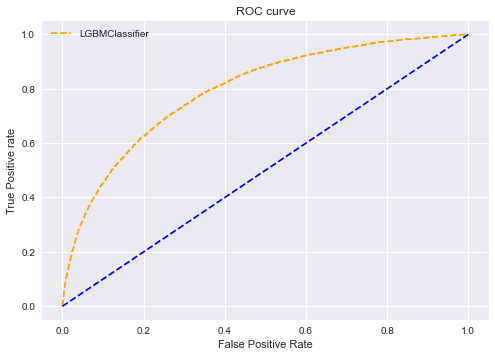

In [31]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='orange', label='LGBMClassifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Logs

In [32]:
run = neptune.init(project='mila1/Credit',
                   api_token='')
run["parameters"] = lgbm_params
run["sys/tags"].add(["LGBM"])
run["auc_score"] = auc_score
run.stop()

https://app.neptune.ai/mila1/Credit/e/CRED-21
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 32 operations to synchronize with Neptune. Do not kill this process.


All 32 operations synced, thanks for waiting!


#### Submission

In [33]:
pred = clf.predict_proba(test_final)
output = pd.DataFrame({'SK_ID_CURR': test_df['SK_ID_CURR'],
                       'TARGET': pred[:,1]})
output.to_csv('lgbm.csv', index=False)
output.head()

SK_ID_CURR    TARGET
307511      100001  0.015279
307512      100005  0.100604
307513      100013  0.020741
307514      100028  0.025777
307515      100038  0.105191

#### Feature importance

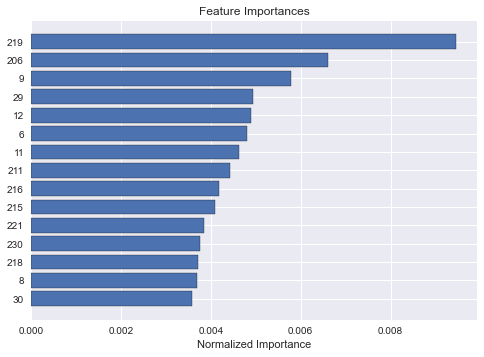

index  features  importance  importance_normalized
0    219       219        4790               0.009460
1    206       206        3340               0.006596
2      9         9        2929               0.005785
3     29        29        2501               0.004939
4     12        12        2477               0.004892
5      6         6        2436               0.004811
6     11        11        2342               0.004625
7    211       211        2241               0.004426
8    216       216        2118               0.004183
9    215       215        2071               0.004090

In [42]:
feature_importance = pd.DataFrame(pd.Series(clf.feature_importances_))
feature_importance = feature_importance.reset_index().rename(columns = {'index':'features', 0:'importance'})
plot_feature_importances(feature_importance).head(10)

## XGBboost

#### Baseline model

In [43]:
xgboost_params = {
    'objective': "binary:logistic",
    'booster': "gbtree",
    'eval_metric': "auc",
    'nthread': 4,
    'random_state': RANDOM_STATE
}

In [44]:
%%time

xgb = XGBClassifier(**xgboost_params)

xgb.fit(X_train, y_train)
y_train_pred = xgb.predict_proba(X_train)
y_test_pred = xgb.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
auc_score_2 = roc_auc_score(y_test, y_test_pred[:,1])
print(auc_score_2)

0.7745376615814235
Wall time: 39min 1s


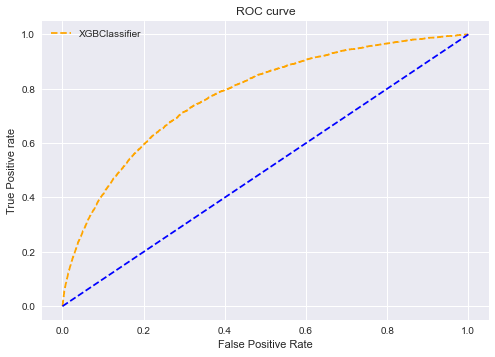

In [45]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='orange', label='XGBClassifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Logs

In [46]:
run = neptune.init(project='mila1/Credit',
                   api_token='')
run["parameters"] = xgboost_params
run["sys/tags"].add(["XGB"])
run["auc_score"] = auc_score_2
run.stop()

https://app.neptune.ai/mila1/Credit/e/CRED-22
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 22 operations to synchronize with Neptune. Do not kill this process.


All 22 operations synced, thanks for waiting!


#### Submission

In [47]:
pred = xgb.predict_proba(test_final)
output = pd.DataFrame({'SK_ID_CURR': test_df['SK_ID_CURR'],
                       'TARGET': pred[:,1]})
output.to_csv('xgb.csv', index=False)
output.head()

SK_ID_CURR    TARGET
307511      100001  0.010477
307512      100005  0.094998
307513      100013  0.019021
307514      100028  0.036962
307515      100038  0.127911

#### Feature importance

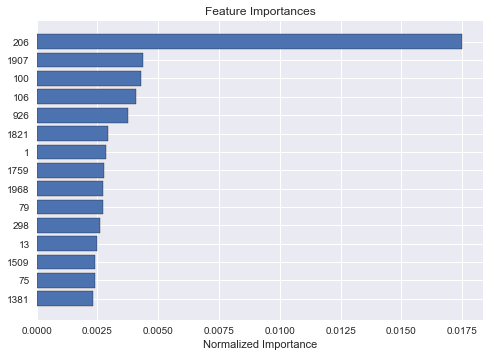

index  features  importance  importance_normalized
0    206       206    0.017485               0.017485
1   1907      1907    0.004391               0.004391
2    100       100    0.004297               0.004297
3    106       106    0.004063               0.004063
4    926       926    0.003761               0.003761
5   1821      1821    0.002940               0.002940
6      1         1    0.002846               0.002846
7   1759      1759    0.002774               0.002774
8   1968      1968    0.002730               0.002730
9     79        79    0.002714               0.002714

In [48]:
feature_importance = pd.DataFrame(pd.Series(xgb.feature_importances_))
feature_importance = feature_importance.reset_index().rename(columns = {'index':'features', 0:'importance'})
plot_feature_importances(feature_importance).head(10)

## Random forest

#### Baseline model

In [49]:
%%time

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
y_train_pred = rfc.predict_proba(X_train)
y_test_pred = rfc.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
auc_score_3 = roc_auc_score(y_test, y_test_pred[:,1])
print(auc_score_3)

0.7244141226661633
Wall time: 16min 28s


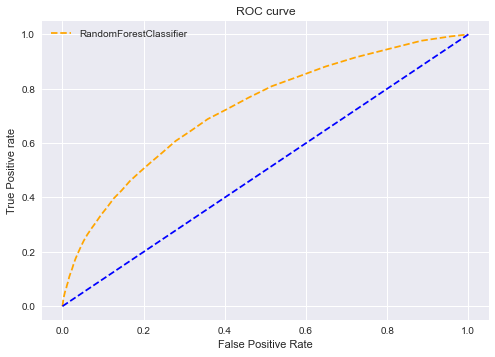

In [50]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='orange', label='RandomForestClassifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Logs

In [51]:
run = neptune.init(project='mila1/Credit',
                   api_token='')
run["sys/tags"].add(["RFC"])
run["auc_score"] = auc_score_3
run.stop()

https://app.neptune.ai/mila1/Credit/e/CRED-23
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.


All 17 operations synced, thanks for waiting!


#### Submission

In [52]:
test_final.reset_index(drop=True)
test_final.fillna(0, inplace=True)
pred = rfc.predict_proba(test_final)
output = pd.DataFrame({'SK_ID_CURR': test_df['SK_ID_CURR'],
                       'TARGET': pred[:,1]})
output.to_csv('rfc.csv', index=False)
output.head()

SK_ID_CURR  TARGET
307511      100001    0.20
307512      100005    0.28
307513      100013    0.19
307514      100028    0.20
307515      100038    0.23

#### Feature importance

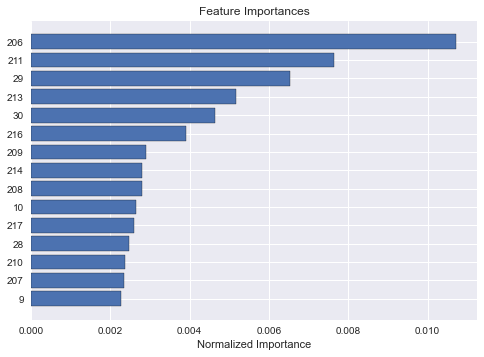

index  features  importance  importance_normalized
0    206       206    0.010723               0.010723
1    211       211    0.007633               0.007633
2     29        29    0.006520               0.006520
3    213       213    0.005165               0.005165
4     30        30    0.004629               0.004629
5    216       216    0.003903               0.003903
6    209       209    0.002887               0.002887
7    214       214    0.002810               0.002810
8    208       208    0.002800               0.002800
9     10        10    0.002650               0.002650

In [53]:
feature_importance = pd.DataFrame(pd.Series(rfc.feature_importances_))
feature_importance = feature_importance.reset_index().rename(columns = {'index':'features', 0:'importance'})
plot_feature_importances(feature_importance).head(10)

#### Summary scores

In [54]:
pd.DataFrame([[auc_score, auc_score_2, auc_score_3], [0.78709, 0.75988, 0.68715], [0.78535, 0.75911, 0.70013]], 
             columns=list(['LGBM','XGB','RFC']), 
             index=['Roc', 'Private', 'Public'])

LGBM       XGB       RFC
Roc      0.794227  0.774538  0.724414
Private  0.787090  0.759880  0.687150
Public   0.785350  0.759110  0.700130

___________________________________________________________________________________________________________________________